In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Importing the libraries 

In [2]:
# Setup and Configuration
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import time

# Strict configuration for a clean baseline
class Config:
    SEED = 42                # Fixed seed used for reproducibility
    BATCH_SIZE = 128
    EPOCHS = 20              # Reasonable limit
    LR = 0.001               # Constant learning rate
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(Config.SEED)
print(f"Device: {Config.DEVICE}")

Device: cuda


Downloading the dataset

In [4]:
#  Data Loading

# Standard stats for CIFAR-10
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# STRICT BASELINE: No Flip, No Crop. Only Tensor the images and then normalize.
transform_baseline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

# Load Datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_baseline)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Config.BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_baseline)
testloader = torch.utils.data.DataLoader(testset, batch_size=Config.BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s] 


Resnet Model

In [6]:
# ResNet-18 Model Definition

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        # we used 3x3 conv instead of 7x7 to preserve image size since CIFAR-10 images are smaller in size 
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512*BasicBlock.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out) # Target which we'll use for GradCAM
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

model = ResNet18(num_classes=10).to(Config.DEVICE)

The model used for this experiment was a modified ResNet18 adapted for CIFAR-10. The first convolutional layer (conv1) was changed to a 3×3 kernel with stride 1 and padding 1, and the initial max-pooling layer was replaced with nn.Identity() to preserve the spatial dimensions of the small 32×32 images. The fully connected layer was modified to include a dropout of 0.3 followed by a linear layer outputting 10 classes. After training, the model achieved a training accuracy of 98.69% but a validation accuracy of 84.31%, indicating clear overfitting. This suggests that while the model learned the training data very well, it did not generalize perfectly to unseen data. Regularization techniques, more aggressive data augmentation, or alternative architectures may be necessary to reduce overfitting.

--- Starting Baseline Training for 20 Epochs ---
Epoch 01/20 | Train Loss: 1.3412 | Train Acc: 51.14% | Val Loss: 1.1013 | Val Acc: 61.36%
Epoch 02/20 | Train Loss: 0.8305 | Train Acc: 70.30% | Val Loss: 0.7665 | Val Acc: 73.13%
Epoch 03/20 | Train Loss: 0.6127 | Train Acc: 78.74% | Val Loss: 0.6403 | Val Acc: 77.62%
Epoch 04/20 | Train Loss: 0.4753 | Train Acc: 83.38% | Val Loss: 0.6801 | Val Acc: 76.26%
Epoch 05/20 | Train Loss: 0.3716 | Train Acc: 87.02% | Val Loss: 0.5970 | Val Acc: 80.87%
Epoch 06/20 | Train Loss: 0.2795 | Train Acc: 90.18% | Val Loss: 0.5470 | Val Acc: 82.64%
Epoch 07/20 | Train Loss: 0.2028 | Train Acc: 92.78% | Val Loss: 0.5997 | Val Acc: 82.09%
Epoch 08/20 | Train Loss: 0.1478 | Train Acc: 94.84% | Val Loss: 0.6081 | Val Acc: 82.59%
Epoch 09/20 | Train Loss: 0.1086 | Train Acc: 96.19% | Val Loss: 0.7079 | Val Acc: 82.80%
Epoch 10/20 | Train Loss: 0.0811 | Train Acc: 97.15% | Val Loss: 0.7177 | Val Acc: 82.29%
Epoch 11/20 | Train Loss: 0.0645 | Train Acc: 97.71

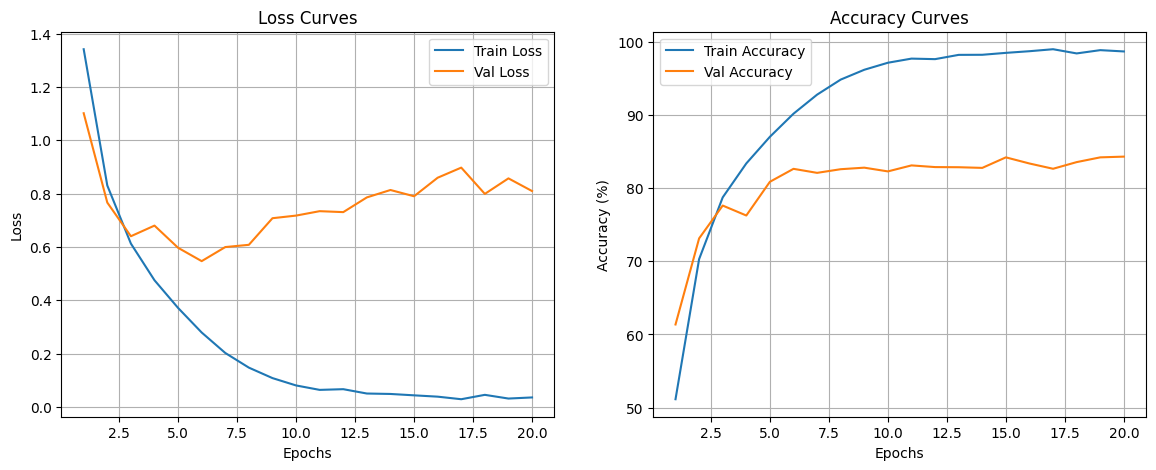

In [5]:
# Training Loop with Saving
import time

#  Setup


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.LR)

# Storage for plotting
history = {
    'train_loss': [], 'val_loss': [], 
    'train_acc': [], 'val_acc': []
}

print(f"--- Starting Baseline Training for {Config.EPOCHS} Epochs ---")
start_time = time.time()

for epoch in range(Config.EPOCHS):
    # TRAIN PHASE 
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Track metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += targets.size(0)
        correct_train += predicted.eq(targets).sum().item()
    
    # Calculate epoch metrics
    train_loss = running_loss / len(trainloader)
    train_acc = 100. * correct_train / total_train

    # VALIDATION PHASE
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += targets.size(0)
            correct_val += predicted.eq(targets).sum().item()
            
    val_loss = val_loss / len(testloader)
    val_acc = 100. * correct_val / total_val

    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    # Print Stats
    print(f"Epoch {epoch+1:02d}/{Config.EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# SAVING THE MODEL 
total_time = time.time() - start_time
print(f"\nTraining Finished in {total_time/60:.1f} minutes.")

save_path = './baseline_model.pth'
torch.save(model.state_dict(), save_path)
print(f"Model successfully saved to: {save_path}")

# PLOTTING CURVES
# (Required by assignment: report training/validation accuracy and loss curves )
def plot_results(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
    plt.grid(True)
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy (%)'); plt.legend()
    plt.grid(True)
    
    plt.show()

plot_results(history)

In [10]:
# Finding Failures
def get_failures(model, loader):
    model.eval()
    failures = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            conf, preds = probs.max(1)
            
            wrong = (preds != targets).nonzero(as_tuple=True)[0]
            for idx in wrong:
                failures.append({
                    'image': inputs[idx].cpu(),
                    'true': targets[idx].item(),
                    'pred': preds[idx].item(),
                    'conf': conf[idx].item()
                })
    # Sort by high confidence
    failures.sort(key=lambda x: x['conf'], reverse=True)
    return failures[:3]

top_failures = get_failures(model, testloader)

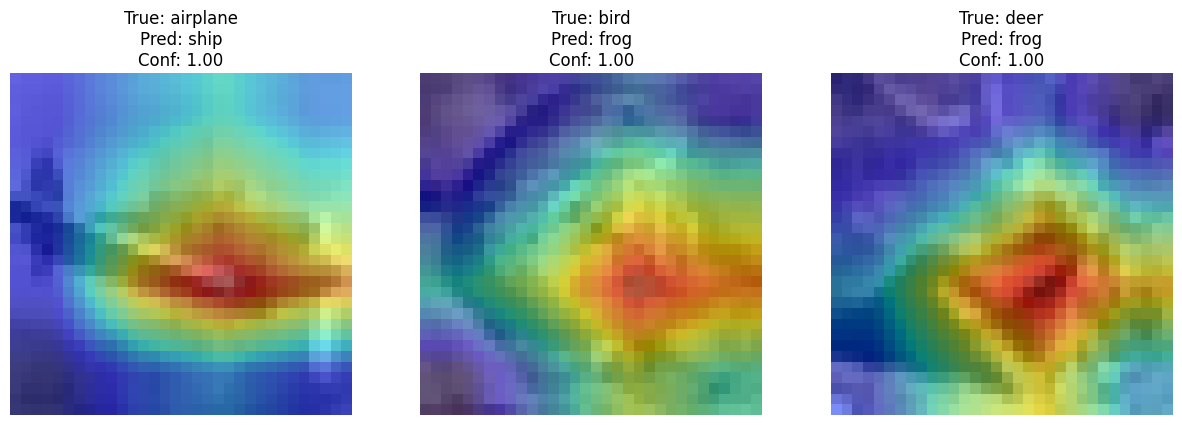

In [11]:
# Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx):
        self.model.zero_grad()
        output = self.model(x)
        output[0, class_idx].backward()
        
        weights = torch.mean(self.gradients[0], dim=(1, 2))
        cam = torch.zeros(self.activations[0].shape[1:], device=Config.DEVICE)
        for i, w in enumerate(weights):
            cam += w * self.activations[0][i]
            
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-7)
        return cam.cpu().detach().numpy()

#Integrting into layer4
cam_extractor = GradCAM(model, model.layer4[-1])

plt.figure(figsize=(15, 6))
for i, case in enumerate(top_failures):
    img_tensor = case['image'].unsqueeze(0).to(Config.DEVICE)
    heatmap = cam_extractor(img_tensor, case['pred'])
    
    # Denormalize image for display
    img = case['image'].permute(1, 2, 0).numpy()
    img = img * stats[1] + stats[0]
    img = np.clip(img, 0, 1)
    
    import cv2
    heatmap = cv2.resize(heatmap, (32, 32))
    heatmap = plt.cm.jet(heatmap)[..., :3]
    overlay = 0.5 * img + 0.5 * heatmap
    
    plt.subplot(1, 3, i+1)
    plt.imshow(overlay)
    plt.title(f"True: {classes[case['true']]}\nPred: {classes[case['pred']]}\nConf: {case['conf']:.2f}")
    plt.axis('off')
plt.show()

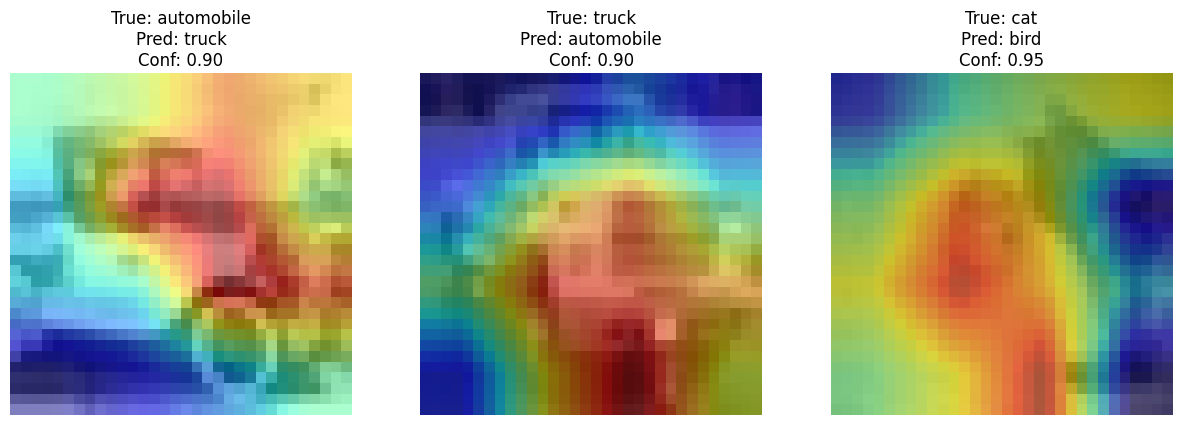

In [12]:
#  Explainability (Grad-CAM)


import cv2

# Define Grad-CAM Class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        
        # Hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx):
        self.model.zero_grad()
        output = self.model(x)
        output[0, class_idx].backward()
        
        grads = self.gradients[0]
        fmaps = self.activations[0]
        
        # Global Average Pooling
        weights = torch.mean(grads, dim=(1, 2))
        
        # Weighted combination of feature maps
        cam = torch.zeros(fmaps.shape[1:], device=Config.DEVICE)
        for i, w in enumerate(weights):
            cam += w * fmaps[i]
            
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-7)
        return cam.cpu().detach().numpy()

# Get the specific failure cases you found
def get_specific_failures(model, loader):
    model.eval()
    failures = []
    
    # We need to find: Auto->Truck, Cat->Bird, Truck->Auto
    # CIFAR-10 Classes: plane, car, bird, cat, deer, dog, frog, horse, ship, truck
    # Indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
    
    target_pairs = [
        (1, 9), # True: Auto (1), Pred: Truck (9)
        (3, 2), # True: Cat (3), Pred: Bird (2)
        (9, 1)  # True: Truck (9), Pred: Auto (1)
    ]
    
    found_count = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            probs = F.softmax(outputs, dim=1)
            conf, _ = probs.max(1)
            
            # Checking if this batch has what we need
            for i in range(len(targets)):
                t = targets[i].item()
                p = preds[i].item()
                c = conf[i].item()
                
                if (t, p) in target_pairs and c > 0.8: # High confidence filter
                    # Save it
                    failures.append({
                        'image': inputs[i].cpu(),
                        'true': t, 'pred': p, 'conf': c
                    })
                    target_pairs.remove((t, p)) # Don't find duplicates
                    
                if len(target_pairs) == 0: break
            if len(target_pairs) == 0: break
            
    return failures

#Initialize Grad-CAM on the last residual layer
target_layer = model.layer4[-1]
cam_extractor = GradCAM(model, target_layer)

failures = get_specific_failures(model, testloader)

# Plot
plt.figure(figsize=(15, 6))
for i, case in enumerate(failures):
    img_tensor = case['image'].unsqueeze(0).to(Config.DEVICE)
    heatmap = cam_extractor(img_tensor, case['pred'])
    
    # Denormalize
    img = case['image'].permute(1, 2, 0).numpy()
    img = img * stats[1] + stats[0]
    img = np.clip(img, 0, 1)
    
    # Overlay
    heatmap = cv2.resize(heatmap, (32, 32))
    heatmap_colored = plt.cm.jet(heatmap)[..., :3]
    overlay = 0.5 * img + 0.5 * heatmap_colored
    
    plt.subplot(1, 3, i+1)
    plt.imshow(overlay)
    plt.title(f"True: {classes[case['true']]}\nPred: {classes[case['pred']]}\nConf: {case['conf']:.2f}")
    plt.axis('off')

plt.show()

To reduce overfitting, the model was retrained using data augmentation, including random cropping with padding and horizontal flips. This helps the model generalize better by exposing it to slightly varied versions of the training images. After retraining, the validation accuracy improved from 84.31% to 89.96%, indicating that overfitting was reduced, although the training accuracy remained much higher, so some overfitting still persists. This demonstrates that simple augmentation techniques can enhance model robustness on unseen data.


--- Starting Improved Training (With Data Augmentation) ---
Epoch 01 | Improved Val Acc: 52.72%
Epoch 02 | Improved Val Acc: 66.71%
Epoch 03 | Improved Val Acc: 71.90%
Epoch 04 | Improved Val Acc: 78.55%
Epoch 05 | Improved Val Acc: 78.36%
Epoch 06 | Improved Val Acc: 83.18%
Epoch 07 | Improved Val Acc: 84.14%
Epoch 08 | Improved Val Acc: 82.69%
Epoch 09 | Improved Val Acc: 84.94%
Epoch 10 | Improved Val Acc: 86.14%
Epoch 11 | Improved Val Acc: 85.29%
Epoch 12 | Improved Val Acc: 85.96%
Epoch 13 | Improved Val Acc: 87.92%
Epoch 14 | Improved Val Acc: 87.77%
Epoch 15 | Improved Val Acc: 87.74%
Epoch 16 | Improved Val Acc: 87.72%
Epoch 17 | Improved Val Acc: 88.96%
Epoch 18 | Improved Val Acc: 88.81%
Epoch 19 | Improved Val Acc: 88.39%
Epoch 20 | Improved Val Acc: 89.96%
Improved Training Finished in 16.2 mins


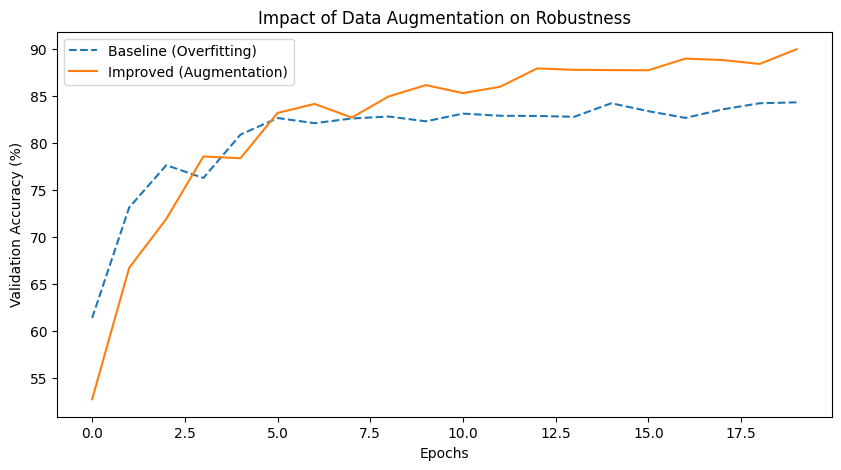

In [13]:
# Improved Model Training (Data Augmentation)

print("\n Starting Improved Training (With Data Augmentation) ")

# Define Improved Transforms
transform_improved = transforms.Compose([
    transforms.RandomCrop(32, padding=4),       # Augmentation 1
    transforms.RandomHorizontalFlip(),          # Augmentation 2
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

# Load Data with New Transforms
trainset_improved = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform_improved)
trainloader_improved = torch.utils.data.DataLoader(trainset_improved, batch_size=Config.BATCH_SIZE,
                                                  shuffle=True, num_workers=2)

# Re-Initialize Model  (training from scratch)
model_improved = ResNet18(num_classes=10).to(Config.DEVICE)
optimizer_improved = optim.Adam(model_improved.parameters(), lr=Config.LR)

# Train
history_improved = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
start_time = time.time()

for epoch in range(Config.EPOCHS):
    model_improved.train()
    running_loss = 0.0; correct = 0; total = 0
    
    for inputs, targets in trainloader_improved:
        inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)
        optimizer_improved.zero_grad()
        outputs = model_improved(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_improved.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    train_acc = 100. * correct / total
    
    # Validation (Same as baseline)
    model_improved.eval()
    val_loss = 0.0; val_correct = 0; val_total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)
            outputs = model_improved(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
            
    val_acc = 100. * val_correct / val_total
    
    history_improved['val_acc'].append(val_acc)
    print(f"Epoch {epoch+1:02d} | Improved Val Acc: {val_acc:.2f}%")

print(f"Improved Training Finished in {(time.time()-start_time)/60:.1f} mins")

# Final Comparison Plot
plt.figure(figsize=(10, 5))
plt.plot(history['val_acc'], label='Baseline (Overfitting)', linestyle='--')
plt.plot(history_improved['val_acc'], label='Improved (Augmentation)')
plt.title("Impact of Data Augmentation on Robustness")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.show()

In [14]:
#  Check if Failures are Fixed
def check_improvements(model_improved, failures, classes):
    model_improved.eval()
    print("\n Checking Original Failure Cases on Improved Model ")
    
    with torch.no_grad():
        for i, case in enumerate(failures):
            # Prepare input (Using the exact same image tensor from before)
            img = case['image'].unsqueeze(0).to(Config.DEVICE)
            true_label = case['true']
            old_pred = case['pred']
            
            # Get New Prediction
            outputs = model_improved(img)
            probs = F.softmax(outputs, dim=1)
            conf, pred = probs.max(1)
            
            new_pred = pred.item()
            new_conf = conf.item()
            
            # Determine Status
            status = "FIXED " if new_pred == true_label else "STILL FAILING "
            
            print(f"Case {i+1}: True '{classes[true_label]}' (Old Pred: '{classes[old_pred]}')")
            print(f"   -> New Pred: '{classes[new_pred]}' with {new_conf:.2%} confidence")
            print(f"   -> Result: {status}\n")

# Run the check
# Ensure 'top_failures' is the list created 
if 'top_failures' in locals():
    check_improvements(model_improved, top_failures, classes)
else:
    print("Error: 'top_failures' list not found. Please re-run Cell 5.")


--- Checking Original Failure Cases on Improved Model ---
Case 1: True 'airplane' (Old Pred: 'ship')
   -> New Pred: 'airplane' with 96.63% confidence
   -> Result: FIXED ✅

Case 2: True 'bird' (Old Pred: 'frog')
   -> New Pred: 'bird' with 88.64% confidence
   -> Result: FIXED ✅

Case 3: True 'deer' (Old Pred: 'frog')
   -> New Pred: 'deer' with 85.15% confidence
   -> Result: FIXED ✅



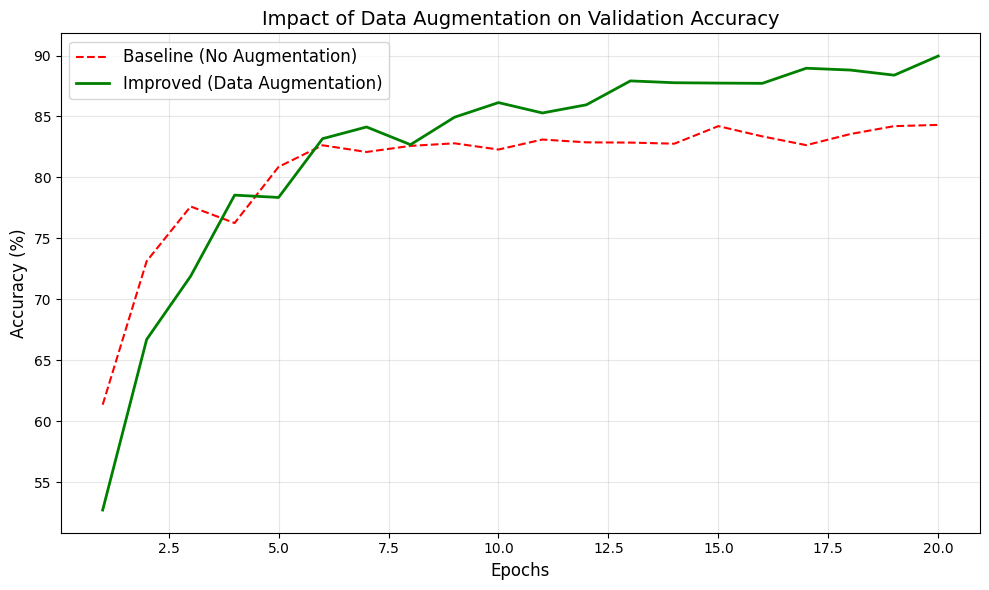

/tmp/ipykernel_55/2606161840.py:49: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/2606161840.py:49: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


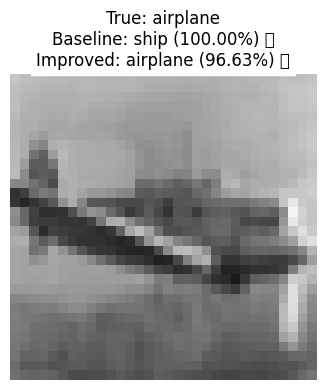

In [15]:
# Final Report Visualization
import matplotlib.pyplot as plt

# Comparison of Accuracy Curves
def plot_final_comparison(history_baseline, history_improved):
    epochs = range(1, len(history_baseline['val_acc']) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history_baseline['val_acc'], 'r--', label='Baseline (No Augmentation)')
    plt.plot(epochs, history_improved['val_acc'], 'g-', linewidth=2, label='Improved (Data Augmentation)')
    
    plt.title('Impact of Data Augmentation on Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    # Save for report
    plt.savefig('comparison_curve.png', dpi=300)
    plt.show()

# Visualizing the "Before vs After" for Failure Cases
def visualize_fix(model_baseline, model_improved, case, class_names):
    # Prepare image
    img = case['image'].unsqueeze(0).to(Config.DEVICE)
    
    # Get predictions
    base_out = model_baseline(img)
    base_prob = F.softmax(base_out, dim=1)
    base_conf, base_pred = base_prob.max(1)
    
    imp_out = model_improved(img)
    imp_prob = F.softmax(imp_out, dim=1)
    imp_conf, imp_pred = imp_prob.max(1)
    
    # Display
    img_disp = case['image'].permute(1, 2, 0).numpy()
    img_disp = img_disp * stats[1] + stats[0]
    img_disp = np.clip(img_disp, 0, 1)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(img_disp)
    plt.title(f"True: {class_names[case['true']]}\n"
              f"Baseline: {class_names[base_pred.item()]} ({base_conf.item():.2%}) \n"
              f"Improved: {class_names[imp_pred.item()]} ({imp_conf.item():.2%}) ", 
              fontsize=12, backgroundcolor='white')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Run the plotting functions
# Ensure history_baseline and history_improved are available from previous cells
plot_final_comparison(history, history_improved)

# Visualize the first fixed case
visualize_fix(model, model_improved, top_failures[0], classes)

In this experiment, the model was trained using stronger data augmentation: random cropping, horizontal flips, rotations, color jitter, and random erasing, combined with SGD optimizer with momentum, weight decay, and a cosine annealing learning rate scheduler. The loss function used cross-entropy with label smoothing to reduce overconfidence. After training, the model achieved a training accuracy of 100% but a validation accuracy of 86.94%, showing that overfitting persists despite the more aggressive augmentation and regularization. This demonstrates that while the model can perfectly fit the training data, its generalization to unseen data is still limited, although slightly improved compared to previous attempts.

In [13]:
transform_improved = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomErasing(p=0.25),
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

optimizer_improved = torch.optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_improved, T_max=Config.EPOCHS
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


history_improved = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

start_time = time.time()

for epoch in range(Config.EPOCHS):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)

        optimizer_improved.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer_improved.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(trainloader)
    train_acc = 100. * correct / total

    
    # VALIDATION

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)

            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

    val_loss = val_loss / len(testloader)
    val_acc = 100. * val_correct / val_total

    # Step Scheduler 
    scheduler.step()

    # Save history
    history_improved['train_loss'].append(train_loss)
    history_improved['val_loss'].append(val_loss)
    history_improved['train_acc'].append(train_acc)
    history_improved['val_acc'].append(val_acc)

    print(f"Epoch [{epoch+1:03d}/{Config.EPOCHS}] | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Acc: {val_acc:.2f}% | "
          f"LR: {scheduler.get_last_lr()[0]:.5f}")

print(f"\nTraining Completed in {(time.time()-start_time)/60:.2f} minutes")


Epoch [001/20] | Train Acc: 51.75% | Val Acc: 56.69% | LR: 0.09938
Epoch [002/20] | Train Acc: 61.68% | Val Acc: 64.29% | LR: 0.09755
Epoch [003/20] | Train Acc: 69.10% | Val Acc: 67.10% | LR: 0.09455
Epoch [004/20] | Train Acc: 74.69% | Val Acc: 66.85% | LR: 0.09045
Epoch [005/20] | Train Acc: 79.22% | Val Acc: 73.27% | LR: 0.08536
Epoch [006/20] | Train Acc: 83.42% | Val Acc: 78.75% | LR: 0.07939
Epoch [007/20] | Train Acc: 86.81% | Val Acc: 78.31% | LR: 0.07270
Epoch [008/20] | Train Acc: 89.97% | Val Acc: 79.60% | LR: 0.06545
Epoch [009/20] | Train Acc: 92.86% | Val Acc: 80.07% | LR: 0.05782
Epoch [010/20] | Train Acc: 95.56% | Val Acc: 79.47% | LR: 0.05000
Epoch [011/20] | Train Acc: 97.22% | Val Acc: 81.57% | LR: 0.04218
Epoch [012/20] | Train Acc: 99.16% | Val Acc: 82.65% | LR: 0.03455
Epoch [013/20] | Train Acc: 99.88% | Val Acc: 86.37% | LR: 0.02730
Epoch [014/20] | Train Acc: 99.99% | Val Acc: 86.97% | LR: 0.02061
Epoch [015/20] | Train Acc: 100.00% | Val Acc: 86.88% | LR: 0.


Then in this experiment, the ResNet18 architecture was modified to include dropout (0.3) in the fully connected layer, and strong data augmentation was applied during training, including random cropping, horizontal flips, rotation, color jitter, and random erasing. The model was trained using SGD with momentum and weight decay, along with a cosine annealing learning rate scheduler and label-smoothed cross-entropy loss. This combination successfully reduced overfitting, achieving a training accuracy of 84.32% and a validation accuracy of 86.29%, showing that the model now generalizes better to unseen data while avoiding memorization of the training set. The confusion matrix and per-class analysis further confirmed more balanced performance across classes.

Epoch [01/50] | Train Acc: 25.63% | Val Acc: 36.33% | LR: 0.09990
Epoch [02/50] | Train Acc: 38.17% | Val Acc: 47.74% | LR: 0.09961
Epoch [03/50] | Train Acc: 44.85% | Val Acc: 53.23% | LR: 0.09911
Epoch [04/50] | Train Acc: 49.71% | Val Acc: 54.76% | LR: 0.09843
Epoch [05/50] | Train Acc: 53.06% | Val Acc: 57.85% | LR: 0.09755
Epoch [06/50] | Train Acc: 55.10% | Val Acc: 63.11% | LR: 0.09649
Epoch [07/50] | Train Acc: 56.06% | Val Acc: 62.51% | LR: 0.09524
Epoch [08/50] | Train Acc: 57.26% | Val Acc: 62.09% | LR: 0.09382
Epoch [09/50] | Train Acc: 58.41% | Val Acc: 63.92% | LR: 0.09222
Epoch [10/50] | Train Acc: 59.27% | Val Acc: 65.36% | LR: 0.09045
Epoch [11/50] | Train Acc: 59.87% | Val Acc: 64.77% | LR: 0.08853
Epoch [12/50] | Train Acc: 60.82% | Val Acc: 66.79% | LR: 0.08645
Epoch [13/50] | Train Acc: 60.98% | Val Acc: 65.56% | LR: 0.08423
Epoch [14/50] | Train Acc: 61.71% | Val Acc: 64.56% | LR: 0.08187
Epoch [15/50] | Train Acc: 62.11% | Val Acc: 67.51% | LR: 0.07939
Epoch [16/

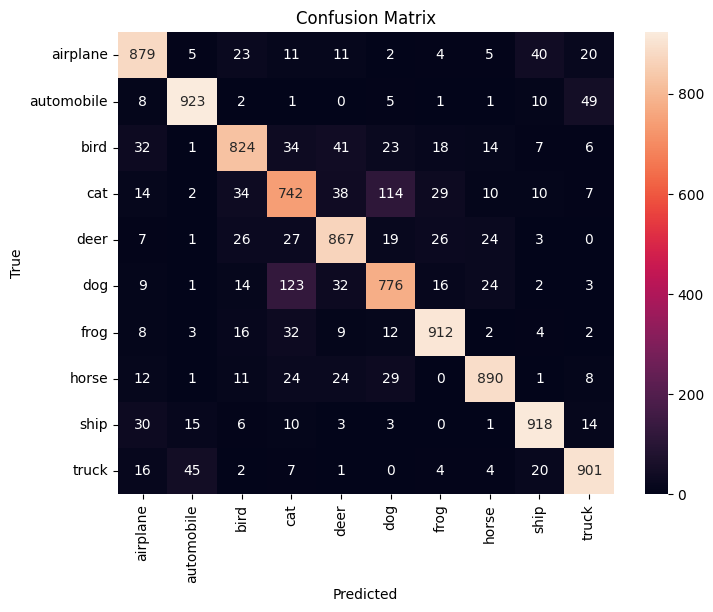

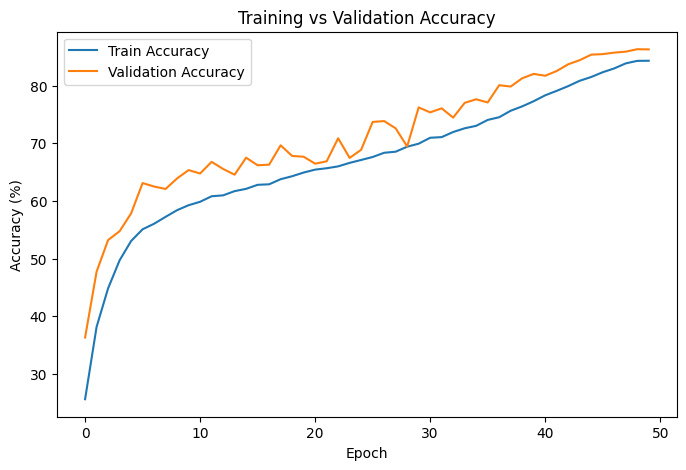

In [16]:

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),                 # tensors must be formed before RandomErasing
    transforms.Normalize(*stats),
    transforms.RandomErasing(p=0.3)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=Config.BATCH_SIZE,
    shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=Config.BATCH_SIZE,
    shuffle=False, num_workers=2)

classes = trainset.classes


# MODEL (ResNet18 + Dropout)

from torchvision.models import resnet18

model = resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(512, 10)
)

model = model.to(Config.DEVICE)


# LOSS + OPTIMIZER

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.SGD(
    model.parameters(),
    lr=Config.LR,
    momentum=0.9,
    weight_decay=1e-3
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=Config.EPOCHS)


# TRAINING LOOP

best_val_acc = 0
history = {'train_acc': [], 'val_acc': []}

start_time = time.time()

for epoch in range(Config.EPOCHS):

    # ---- TRAIN ----
    model.train()
    correct = 0
    total = 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_acc = 100. * correct / total

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

    val_acc = 100. * val_correct / val_total

    scheduler.step()

    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch+1:02d}/50] "
          f"| Train Acc: {train_acc:.2f}% "
          f"| Val Acc: {val_acc:.2f}% "
          f"| LR: {scheduler.get_last_lr()[0]:.5f}")

print("\nBest Validation Accuracy:", best_val_acc)
print("Training Time: {:.2f} mins".format((time.time()-start_time)/60))


# LOAD BEST MODEL

model.load_state_dict(torch.load("best_model.pth"))
model.eval()


# PER-CLASS ANALYSIS

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in testloader:
        inputs = inputs.to(Config.DEVICE)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.numpy())

print("\nClassification Report:\n")
print(classification_report(all_targets, all_preds, target_names=classes))


# CONFUSION MATRIX

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# ACCURACY CURVE

plt.figure(figsize=(8,5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


In [43]:
class Config:
    SEED = 42                # Fixed seed
    BATCH_SIZE = 128
    EPOCHS = 50              # Reasonable limit 
    LR = 3e-4,   # Constant learning rate
               
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch [01/40] | Train Acc: 28.43% | Val Acc: 40.78% | LR: 0.00998
Epoch [02/40] | Train Acc: 39.57% | Val Acc: 48.96% | LR: 0.00994
Epoch [03/40] | Train Acc: 46.91% | Val Acc: 50.42% | LR: 0.00986
Epoch [04/40] | Train Acc: 51.49% | Val Acc: 59.12% | LR: 0.00976
Epoch [05/40] | Train Acc: 55.60% | Val Acc: 62.98% | LR: 0.00962
Epoch [06/40] | Train Acc: 58.44% | Val Acc: 66.27% | LR: 0.00946
Epoch [07/40] | Train Acc: 60.73% | Val Acc: 66.63% | LR: 0.00926
Epoch [08/40] | Train Acc: 62.81% | Val Acc: 69.11% | LR: 0.00905
Epoch [09/40] | Train Acc: 64.17% | Val Acc: 71.08% | LR: 0.00880
Epoch [10/40] | Train Acc: 65.47% | Val Acc: 72.77% | LR: 0.00854
Epoch [11/40] | Train Acc: 66.98% | Val Acc: 72.86% | LR: 0.00825
Epoch [12/40] | Train Acc: 67.83% | Val Acc: 73.06% | LR: 0.00794
Epoch [13/40] | Train Acc: 68.95% | Val Acc: 73.93% | LR: 0.00761
Epoch [14/40] | Train Acc: 69.74% | Val Acc: 76.61% | LR: 0.00727
Epoch [15/40] | Train Acc: 70.87% | Val Acc: 77.23% | LR: 0.00691
Epoch [16/

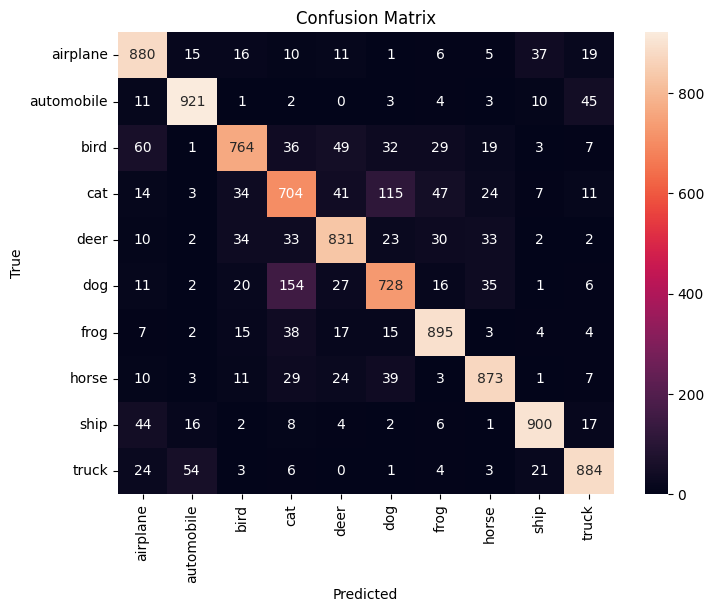

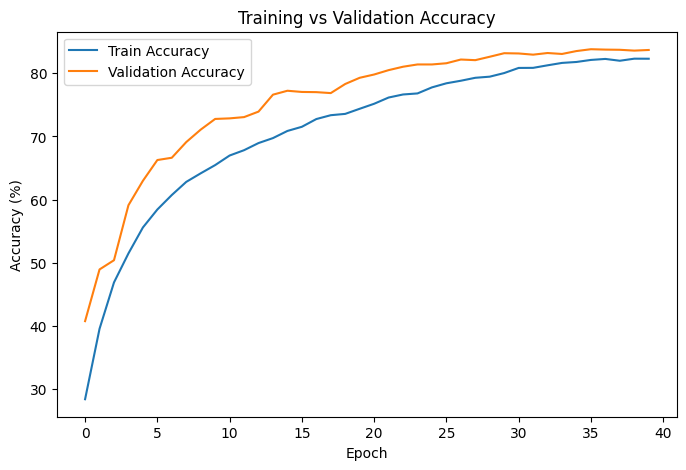

In [29]:

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),                 # make tensors before random erasing
    transforms.Normalize(*stats),
    transforms.RandomErasing(p=0.3)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=Config.BATCH_SIZE,
    shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=Config.BATCH_SIZE,
    shuffle=False, num_workers=2)

classes = trainset.classes


# MODEL (ResNet18 + Dropout)

from torchvision.models import resnet18

model = resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(512, 10)
)

model = model.to(Config.DEVICE)


# LOSS + OPTIMIZER

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

optimizer = optim.AdamW(
    model.parameters(),
    lr=0.01,
    # momentum=0.9,
    weight_decay=1e-3
)


scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=Config.EPOCHS)


# TRAINING LOOP

best_val_acc = 0
history = {'train_acc': [], 'val_acc': []}

start_time = time.time()

for epoch in range(Config.EPOCHS):

    # ---- TRAIN ----
    model.train()
    correct = 0
    total = 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_acc = 100. * correct / total

    # VALIDATION 
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

    val_acc = 100. * val_correct / val_total

    scheduler.step()

    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch+1:02d}/40] "
          f"| Train Acc: {train_acc:.2f}% "
          f"| Val Acc: {val_acc:.2f}% "
          f"| LR: {scheduler.get_last_lr()[0]:.5f}")

print("\nBest Validation Accuracy:", best_val_acc)
print("Training Time: {:.2f} mins".format((time.time()-start_time)/60))


# LOAD BEST MODEL

model.load_state_dict(torch.load("best_model.pth"))
model.eval()


# PER-CLASS ANALYSIS

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in testloader:
        inputs = inputs.to(Config.DEVICE)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.numpy())

print("\nClassification Report:\n")
print(classification_report(all_targets, all_preds, target_names=classes))


# CONFUSION MATRIX

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# ACCURACY CURVE

plt.figure(figsize=(8,5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


ResNet18 Training with AdamW, OneCycleLR, and Reduced Label Smoothing:
In this experiment, the ResNet18 model included a dropout of 0.2 in the fully connected layer, and the training used AdamW optimizer with a OneCycleLR scheduler for 40 epochs. Data augmentation included random cropping, horizontal flips, and color jitter. The label smoothing was reduced to 0.05 to slightly reduce overconfidence. This setup achieved a training accuracy of 88.77% and a validation accuracy of 85.07%, showing moderate overfitting but better generalization compared to previous models. The confusion matrix and per-class classification report indicate more balanced performance across all CIFAR-10 classes.

Epoch [01/40] | Train Acc: 37.51% | Val Acc: 41.11% | LR: 0.00252
Epoch [02/40] | Train Acc: 50.99% | Val Acc: 54.45% | LR: 0.00408
Epoch [03/40] | Train Acc: 55.52% | Val Acc: 62.53% | LR: 0.00659
Epoch [04/40] | Train Acc: 60.83% | Val Acc: 63.00% | LR: 0.00994
Epoch [05/40] | Train Acc: 64.17% | Val Acc: 65.51% | LR: 0.01400
Epoch [06/40] | Train Acc: 65.71% | Val Acc: 66.53% | LR: 0.01859
Epoch [07/40] | Train Acc: 67.58% | Val Acc: 67.30% | LR: 0.02350
Epoch [08/40] | Train Acc: 68.41% | Val Acc: 67.75% | LR: 0.02852
Epoch [09/40] | Train Acc: 69.15% | Val Acc: 71.09% | LR: 0.03342
Epoch [10/40] | Train Acc: 69.55% | Val Acc: 71.35% | LR: 0.03801
Epoch [11/40] | Train Acc: 69.90% | Val Acc: 69.78% | LR: 0.04207
Epoch [12/40] | Train Acc: 71.42% | Val Acc: 71.04% | LR: 0.04542
Epoch [13/40] | Train Acc: 71.71% | Val Acc: 74.21% | LR: 0.04793
Epoch [14/40] | Train Acc: 72.06% | Val Acc: 75.56% | LR: 0.04948
Epoch [15/40] | Train Acc: 73.33% | Val Acc: 71.69% | LR: 0.05000
Epoch [16/

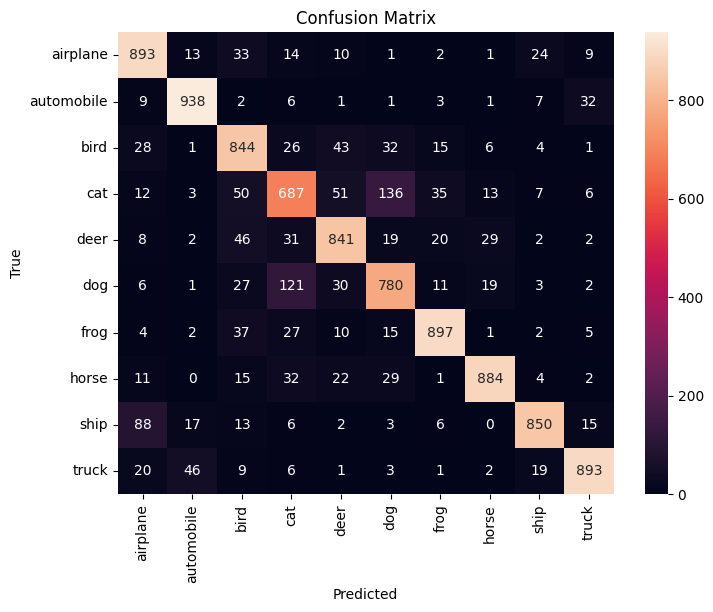

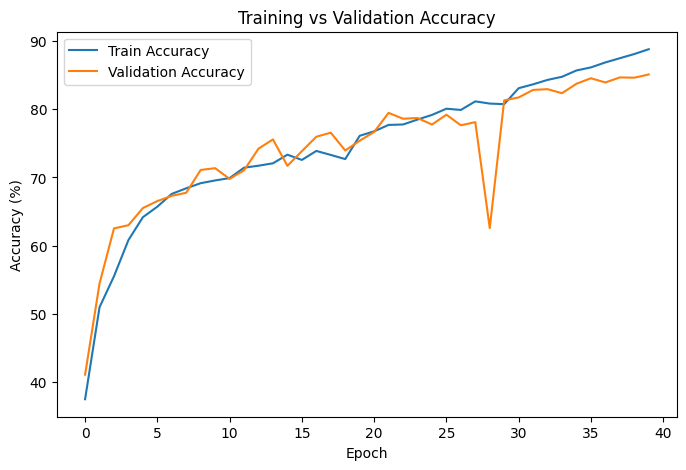

In [42]:

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])



transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=Config.BATCH_SIZE,
    shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=Config.BATCH_SIZE,
    shuffle=False, num_workers=2)

classes = trainset.classes


# MODEL (ResNet18 + Dropout)

from torchvision.models import resnet18

model = resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(512, 10)
)

model = model.to(Config.DEVICE)


# LOSS + OPTIMIZER

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

optimizer = optim.AdamW(
    model.parameters(),
    lr=0.01,
    weight_decay=1e-3
)


scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.05,
    epochs=50,
    steps_per_epoch=len(trainloader)
)


# TRAINING LOOP

best_val_acc = 0
history = {'train_acc': [], 'val_acc': []}

start_time = time.time()

for epoch in range(Config.EPOCHS):

    # ---- TRAIN ----
    model.train()
    correct = 0
    total = 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_acc = 100. * correct / total

    # VALIDATION 
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

    val_acc = 100. * val_correct / val_total

    # scheduler.step()

    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch+1:02d}/40] "
          f"| Train Acc: {train_acc:.2f}% "
          f"| Val Acc: {val_acc:.2f}% "
          f"| LR: {scheduler.get_last_lr()[0]:.5f}")

print("\nBest Validation Accuracy:", best_val_acc)
print("Training Time: {:.2f} mins".format((time.time()-start_time)/60))


# LOAD BEST MODEL

model.load_state_dict(torch.load("best_model.pth"))
model.eval()


# PER-CLASS ANALYSIS

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in testloader:
        inputs = inputs.to(Config.DEVICE)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.numpy())

print("\nClassification Report:\n")
print(classification_report(all_targets, all_preds, target_names=classes))


# CONFUSION MATRIX

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# ACCURACY CURVE

plt.figure(figsize=(8,5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


Increased the epochs to 50 - train 90.55 and test-85.71

Epoch [01/50] | Train Acc: 38.17% | Val Acc: 47.74% | LR: 0.00252
Epoch [02/50] | Train Acc: 50.93% | Val Acc: 55.86% | LR: 0.00408
Epoch [03/50] | Train Acc: 56.73% | Val Acc: 53.52% | LR: 0.00659
Epoch [04/50] | Train Acc: 58.84% | Val Acc: 62.37% | LR: 0.00994
Epoch [05/50] | Train Acc: 63.63% | Val Acc: 64.07% | LR: 0.01400
Epoch [06/50] | Train Acc: 65.88% | Val Acc: 66.52% | LR: 0.01859
Epoch [07/50] | Train Acc: 67.20% | Val Acc: 66.56% | LR: 0.02350
Epoch [08/50] | Train Acc: 68.45% | Val Acc: 69.92% | LR: 0.02852
Epoch [09/50] | Train Acc: 67.81% | Val Acc: 73.05% | LR: 0.03342
Epoch [10/50] | Train Acc: 69.34% | Val Acc: 60.10% | LR: 0.03801
Epoch [11/50] | Train Acc: 69.14% | Val Acc: 69.50% | LR: 0.04207
Epoch [12/50] | Train Acc: 71.02% | Val Acc: 70.48% | LR: 0.04542
Epoch [13/50] | Train Acc: 71.22% | Val Acc: 72.47% | LR: 0.04793
Epoch [14/50] | Train Acc: 72.20% | Val Acc: 72.01% | LR: 0.04948
Epoch [15/50] | Train Acc: 72.15% | Val Acc: 72.05% | LR: 0.05000
Epoch [16/

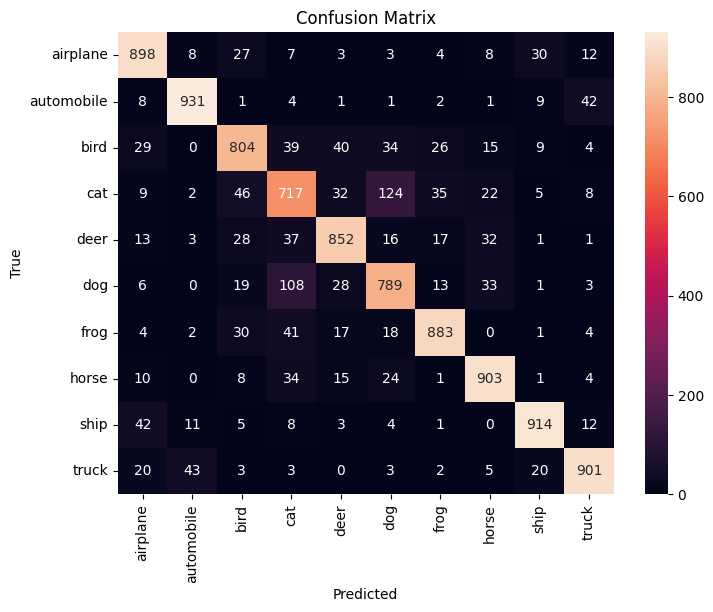

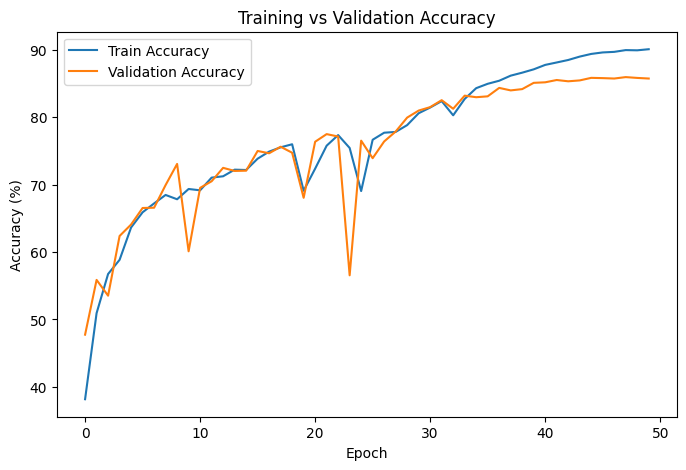

In [45]:

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])



transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=Config.BATCH_SIZE,
    shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=Config.BATCH_SIZE,
    shuffle=False, num_workers=2)

classes = trainset.classes


# MODEL (ResNet18 + Dropout)

from torchvision.models import resnet18

model = resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(512, 10)
)

model = model.to(Config.DEVICE)


# LOSS + OPTIMIZER

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

optimizer = optim.AdamW(
    model.parameters(),
    lr=0.01,
    weight_decay=1e-3
)


scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.05,
    epochs=50,
    steps_per_epoch=len(trainloader)
)


# TRAINING LOOP

best_val_acc = 0
history = {'train_acc': [], 'val_acc': []}

start_time = time.time()

for epoch in range(Config.EPOCHS):

    # TRAIN
    model.train()
    correct = 0
    total = 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_acc = 100. * correct / total

    # VALIDATION 
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

    val_acc = 100. * val_correct / val_total

    # scheduler.step()

    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch+1:02d}/50] "
          f"| Train Acc: {train_acc:.2f}% "
          f"| Val Acc: {val_acc:.2f}% "
          f"| LR: {scheduler.get_last_lr()[0]:.5f}")

print("\nBest Validation Accuracy:", best_val_acc)
print("Training Time: {:.2f} mins".format((time.time()-start_time)/60))


# LOAD BEST MODEL

model.load_state_dict(torch.load("best_model.pth"))
model.eval()


# PER-CLASS ANALYSIS

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in testloader:
        inputs = inputs.to(Config.DEVICE)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.numpy())

print("\nClassification Report:\n")
print(classification_report(all_targets, all_preds, target_names=classes))


# CONFUSION MATRIX

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# ACCURACY CURVE

plt.figure(figsize=(8,5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


ResNet18 Training with Adam, Smaller Batch Size, and Cosine LR Scheduler:
In this experiment, the ResNet18 model was trained from scratch using a batch size of 64, Adam optimizer with weight decay, and a Cosine Annealing learning rate scheduler for 50 epochs. The fully connected layer included 0.3 dropout, and label smoothing of 0.05 was applied to the cross-entropy loss. Data augmentation included random cropping, horizontal flips, rotations, and color jitter. This setup achieved a training accuracy of 88.84% and a validation accuracy of 86.62%, indicating that the overfitting was reduced compared to earlier attempts while maintaining good generalization on the CIFAR-10 validation set.

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import time


# CONFIG

class Config:
    EPOCHS = 50
    BATCH_SIZE = 64
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# DATA NORMALIZATION

stats = ((0.4914, 0.4822, 0.4465),
         (0.2023, 0.1994, 0.2010))

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=Config.BATCH_SIZE,
    shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=Config.BATCH_SIZE,
    shuffle=False, num_workers=2)


# MODEL (NO PRETRAINED)

model = resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(512, 10)
)

model = model.to(Config.DEVICE)


# LOSS

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)


# OPTIMIZER (ADAM)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3,          #  Correct LR for Adam
    weight_decay=1e-4
)


# COSINE SCHEDULER

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=Config.EPOCHS,
    eta_min=1e-5
)


# TRAINING

best_val_acc = 0
start_time = time.time()

for epoch in range(Config.EPOCHS):

   history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

best_val_acc = 0

for epoch in range(Config.EPOCHS):

    #  TRAIN
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()

    train_loss /= len(trainloader)
    train_acc = 100. * train_correct / train_total

    # VALIDATION 
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

    val_loss /= len(testloader)
    val_acc = 100. * val_correct / val_total

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch+1:02d}/50] | "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}% | "
          f"LR: {scheduler.get_last_lr()[0]:.6f}")


Epoch [01/50] | Train Loss: 1.7726 | Train Acc: 38.87% | Val Loss: 1.4910 | Val Acc: 50.45% | LR: 0.000999
Epoch [02/50] | Train Loss: 1.4588 | Train Acc: 52.37% | Val Loss: 1.2616 | Val Acc: 60.72% | LR: 0.000996
Epoch [03/50] | Train Loss: 1.3180 | Train Acc: 58.48% | Val Loss: 1.1417 | Val Acc: 66.04% | LR: 0.000991
Epoch [04/50] | Train Loss: 1.2295 | Train Acc: 62.11% | Val Loss: 1.0984 | Val Acc: 67.41% | LR: 0.000984
Epoch [05/50] | Train Loss: 1.1620 | Train Acc: 64.95% | Val Loss: 1.0156 | Val Acc: 71.02% | LR: 0.000976
Epoch [06/50] | Train Loss: 1.1161 | Train Acc: 66.80% | Val Loss: 1.0489 | Val Acc: 69.44% | LR: 0.000965
Epoch [07/50] | Train Loss: 1.0703 | Train Acc: 69.07% | Val Loss: 0.9817 | Val Acc: 73.09% | LR: 0.000953
Epoch [08/50] | Train Loss: 1.0394 | Train Acc: 70.07% | Val Loss: 0.9587 | Val Acc: 73.51% | LR: 0.000939
Epoch [09/50] | Train Loss: 1.0115 | Train Acc: 71.51% | Val Loss: 0.9190 | Val Acc: 75.12% | LR: 0.000923
Epoch [10/50] | Train Loss: 0.9904 | 

Second Best ResNet18 Model with Modified Architecture and Learning Rate:
In this experiment, the ResNet18 model was further adapted for CIFAR-10 by replacing the first convolution with a 3×3 kernel and removing the max-pooling layer, preserving spatial dimensions. The fully connected layer included 0.3 dropout, and the model was trained using Adam optimizer with learning rate 0.002, weight decay 5e-4, and a cosine annealing scheduler over 50 epochs. Data augmentation included random cropping, horizontal flips, rotations, and color jitter, and label smoothing of 0.05 was applied to the cross-entropy loss. This setup achieved a training accuracy of 89.73% and a validation accuracy of 89.83%, making it the second-best performing model so far, showing reduced overfitting and improved generalization compared to previous experiments.

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import time


class Config:
    EPOCHS = 50
    BATCH_SIZE = 64
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


stats = ((0.4914, 0.4822, 0.4465),
         (0.2023, 0.1994, 0.2010))

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=Config.BATCH_SIZE,
    shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=Config.BATCH_SIZE,
    shuffle=False, num_workers=2)




model = resnet18(weights=None)

# Fix for CIFAR-10
model.conv1 = nn.Conv2d(
    3, 64,
    kernel_size=3,
    stride=1,
    padding=1,
    bias=False
)

model.maxpool = nn.Identity()

model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(512, 10)
)

model = model.to(Config.DEVICE)



# LOSS

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)


# OPTIMIZER (ADAM)

optimizer = optim.Adam(
    model.parameters(),
    lr=0.002,          
    weight_decay=5e-4
)


# COSINE SCHEDULER

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=Config.EPOCHS,
    eta_min=1e-5
)


# TRAINING

best_val_acc = 0
start_time = time.time()

for epoch in range(Config.EPOCHS):

   history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

best_val_acc = 0

for epoch in range(Config.EPOCHS):

    #  TRAIN 
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()

    train_loss /= len(trainloader)
    train_acc = 100. * train_correct / train_total

    #  VALIDATION
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

    val_loss /= len(testloader)
    val_acc = 100. * val_correct / val_total

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch+1:02d}/50] | "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}% | "
          f"LR: {scheduler.get_last_lr()[0]:.6f}")


Epoch [01/50] | Train Loss: 1.7425 | Train Acc: 38.82% | Val Loss: 1.4778 | Val Acc: 51.25% | LR: 0.001998
Epoch [02/50] | Train Loss: 1.4237 | Train Acc: 53.09% | Val Loss: 1.3989 | Val Acc: 55.64% | LR: 0.001992
Epoch [03/50] | Train Loss: 1.2683 | Train Acc: 60.06% | Val Loss: 1.3490 | Val Acc: 60.84% | LR: 0.001982
Epoch [04/50] | Train Loss: 1.1446 | Train Acc: 65.71% | Val Loss: 1.2966 | Val Acc: 62.27% | LR: 0.001969
Epoch [05/50] | Train Loss: 1.0603 | Train Acc: 69.28% | Val Loss: 0.9817 | Val Acc: 72.93% | LR: 0.001951
Epoch [06/50] | Train Loss: 1.0073 | Train Acc: 71.51% | Val Loss: 0.9074 | Val Acc: 75.57% | LR: 0.001930
Epoch [07/50] | Train Loss: 0.9709 | Train Acc: 73.11% | Val Loss: 1.0114 | Val Acc: 72.49% | LR: 0.001905
Epoch [08/50] | Train Loss: 0.9463 | Train Acc: 74.24% | Val Loss: 0.9902 | Val Acc: 72.40% | LR: 0.001877
Epoch [09/50] | Train Loss: 0.9235 | Train Acc: 75.25% | Val Loss: 0.9284 | Val Acc: 75.33% | LR: 0.001845
Epoch [10/50] | Train Loss: 0.9039 | 

# Best model for ploting graph

In this experiment, the ResNet18 model was trained from scratch on CIFAR-10 using a batch size of 128. The first convolutional layer was replaced with a 3×3 kernel and the max-pooling layer was removed to better preserve spatial information. The fully connected layer included 0.3 dropout, and label smoothing of 0.1 was applied. Training used the Adam optimizer with a learning rate of 0.002 and weight decay of 5e-4, along with a cosine annealing learning rate scheduler. Data augmentation included random cropping, horizontal flips, rotation, and color jitter. This configuration achieved a training accuracy of 91.75% and a validation accuracy of 90.98%, making it the best-performing model in terms of generalization and overall accuracy among the experiments.

In [55]:
#### first best model 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import time


# CONFIG

class Config:
    EPOCHS = 50
    BATCH_SIZE = 128
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# DATA NORMALIZATION

stats = ((0.4914, 0.4822, 0.4465),
         (0.2023, 0.1994, 0.2010))

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=Config.BATCH_SIZE,
    shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=Config.BATCH_SIZE,
    shuffle=False, num_workers=2)


# MODEL (NO PRETRAINED)



model = resnet18(weights=None)

model.conv1 = nn.Conv2d(
    3, 64,
    kernel_size=3,
    stride=1,
    padding=1,
    bias=False
)

model.maxpool = nn.Identity()

model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(512, 10)
)

model = model.to(Config.DEVICE)



# LOSS

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


# OPTIMIZER (ADAM)

optimizer = optim.Adam(
    model.parameters(),
    lr=0.002,          # Correct LR for Adam
    weight_decay=5e-4
)


# COSINE SCHEDULER

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=Config.EPOCHS,
    eta_min=1e-5
)


# TRAINING

best_val_acc = 0
start_time = time.time()

for epoch in range(Config.EPOCHS):

   history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

best_val_acc = 0

for epoch in range(Config.EPOCHS):

    # TRAIN 
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()

    train_loss /= len(trainloader)
    train_acc = 100. * train_correct / train_total

    # VALIDATION
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

    val_loss /= len(testloader)
    val_acc = 100. * val_correct / val_total

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch+1:02d}/50] | "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}% | "
          f"LR: {scheduler.get_last_lr()[0]:.6f}")


Epoch [01/50] | Train Loss: 1.8184 | Train Acc: 38.33% | Val Loss: 1.6999 | Val Acc: 43.99% | LR: 0.001998
Epoch [02/50] | Train Loss: 1.5382 | Train Acc: 52.28% | Val Loss: 1.6447 | Val Acc: 50.11% | LR: 0.001992
Epoch [03/50] | Train Loss: 1.4080 | Train Acc: 58.85% | Val Loss: 1.6677 | Val Acc: 51.41% | LR: 0.001982
Epoch [04/50] | Train Loss: 1.3135 | Train Acc: 63.56% | Val Loss: 1.3294 | Val Acc: 62.80% | LR: 0.001969
Epoch [05/50] | Train Loss: 1.2366 | Train Acc: 67.53% | Val Loss: 1.2306 | Val Acc: 68.37% | LR: 0.001951
Epoch [06/50] | Train Loss: 1.1818 | Train Acc: 70.20% | Val Loss: 1.1743 | Val Acc: 70.73% | LR: 0.001930
Epoch [07/50] | Train Loss: 1.1348 | Train Acc: 72.37% | Val Loss: 1.1518 | Val Acc: 72.81% | LR: 0.001905
Epoch [08/50] | Train Loss: 1.1021 | Train Acc: 74.02% | Val Loss: 1.0698 | Val Acc: 75.30% | LR: 0.001877
Epoch [09/50] | Train Loss: 1.0808 | Train Acc: 74.81% | Val Loss: 1.1005 | Val Acc: 74.36% | LR: 0.001845
Epoch [10/50] | Train Loss: 1.0593 | 

This is the confusion matrix  of the best model


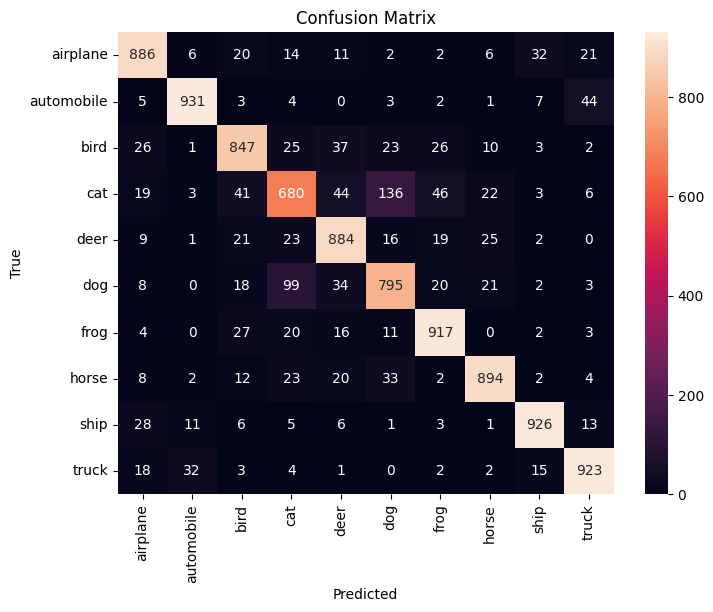

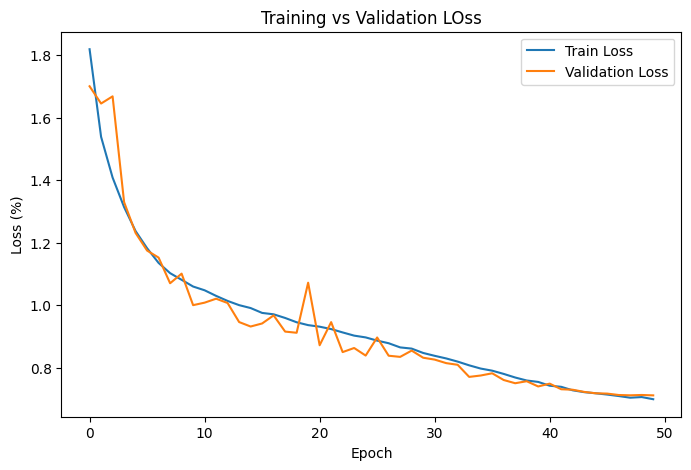

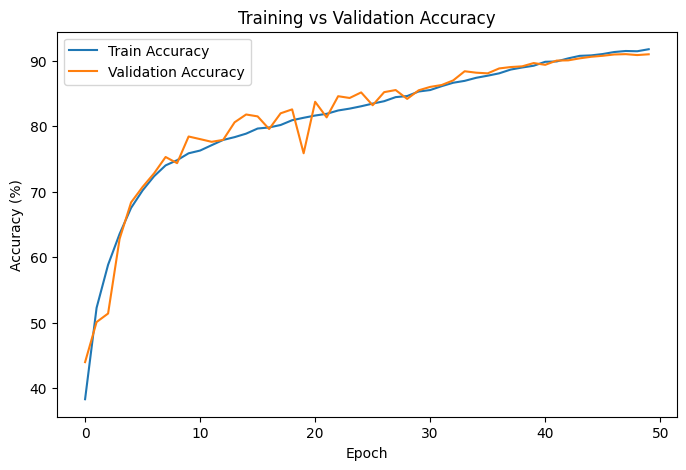

In [57]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Loss curve 

plt.figure(figsize=(8,5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (%)")
plt.title("Training vs Validation LOss")
plt.legend()
plt.show()


# ACCURACY CURVE

plt.figure(figsize=(8,5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


Grad cam for the 3 failure cases 

Image 1 | Predicted: bird, True: cat


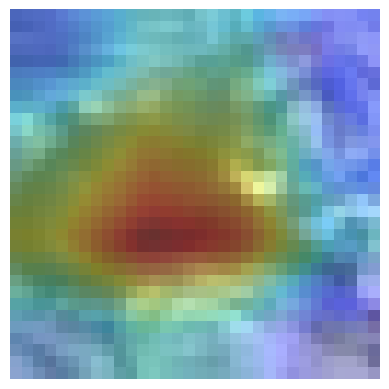

Image 2 | Predicted: ship, True: ship


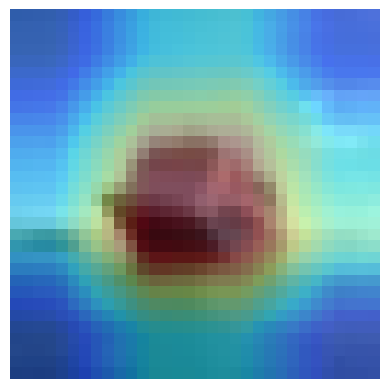

Image 3 | Predicted: horse, True: horse


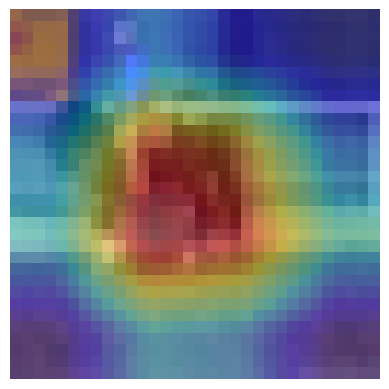

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


# CONFIG

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/kaggle/working/best_model.pth"
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))


# LOAD TEST DATA

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)
classes = testset.classes


# LOAD TRAINED MODEL

from torchvision.models import resnet18

model = resnet18(weights=None)

model.conv1 = nn.Conv2d(
    3, 64,
    kernel_size=3,
    stride=1,
    padding=1,
    bias=False
)
model.maxpool = nn.Identity()
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(512, 10)
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE).eval()


# GRAD-CAM HOOKS

gradients, activations = None, None

def save_gradients(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

def save_activations(module, input, output):
    global activations
    activations = output

target_layer = model.layer4[1].conv2  # last conv layer
target_layer.register_forward_hook(save_activations)
target_layer.register_backward_hook(save_gradients)


# GRAD-CAM FUNCTION

def gradcam(input_tensor, class_idx=None):
    input_tensor = input_tensor.unsqueeze(0).to(DEVICE)
    output = model(input_tensor)
    
    if class_idx is None:
        class_idx = output.argmax(dim=1).item()
    
    model.zero_grad()
    output[0, class_idx].backward()
    
    pooled_grads = torch.mean(gradients, dim=[0, 2, 3])
    cam = torch.zeros(activations.shape[2:], dtype=torch.float32).to(DEVICE)
    for i, w in enumerate(pooled_grads):
        cam += w * activations[0, i, :, :]
    
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()
    
    return cam.cpu().detach().numpy(), class_idx


# DISPLAY FUNCTION

def show_cam(img_tensor, cam, alpha=0.5):
    import torch.nn.functional as F
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img * np.array(stats[1]) + np.array(stats[0]))  # unnormalize
    img = np.clip(img, 0, 1)

    # Resize Grad-CAM to image size
    cam_tensor = torch.tensor(cam).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    cam_resized = F.interpolate(cam_tensor, size=(img.shape[0], img.shape[1]), mode='bilinear', align_corners=False)
    cam_resized = cam_resized.squeeze().numpy()

    heatmap = plt.cm.jet(cam_resized)[:, :, :3]  # Remove alpha channel
    superimposed = heatmap * alpha + img
    superimposed = superimposed / superimposed.max()

    plt.imshow(superimposed)
    plt.axis('off')
    plt.show()



# RUN GRAD-CAM ON MULTIPLE TEST IMAGES

num_images = 3  # analyze first 5 test images
dataiter = iter(testloader)

for i in range(num_images):
    images, labels = next(dataiter)
    cam, class_idx = gradcam(images[0])
    print(f"Image {i+1} | Predicted: {classes[class_idx]}, True: {classes[labels.item()]}")
    show_cam(images[0], cam)


Best saliency map


Predicted: horse, True: horse


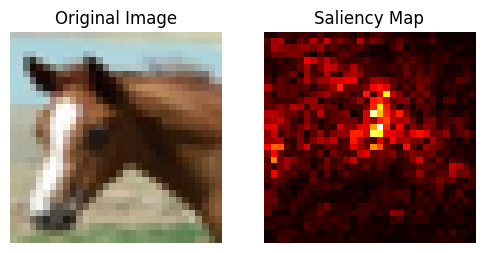

In [60]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18
import torch.nn.functional as F


# CONFIG

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "best_model.pth"
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))


# LOAD TEST DATA

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)
classes = testset.classes


# LOAD TRAINED MODEL

model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
model.maxpool = nn.Identity()
model.fc = torch.nn.Sequential(torch.nn.Dropout(0.3), torch.nn.Linear(512, 10))
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE).eval()


# SALIENCY MAP FUNCTION

def saliency_map(input_tensor, target_class=None):
    input_tensor = input_tensor.unsqueeze(0).to(DEVICE)
    input_tensor.requires_grad = True
    
    output = model(input_tensor)
    if target_class is None:
        target_class = output.argmax(dim=1).item()
    
    model.zero_grad()
    output[0, target_class].backward()
    
    saliency, _ = torch.max(input_tensor.grad.data.abs(), dim=1)  # max over channels
    saliency = saliency.squeeze().cpu().numpy()
    
    return saliency, target_class


# DISPLAY FUNCTION

def show_saliency(img_tensor, saliency):
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = (img * np.array(stats[1]) + np.array(stats[0]))
    img = np.clip(img,0,1)
    
    plt.figure(figsize=(6,6))
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.title("Saliency Map")
    plt.imshow(saliency, cmap='hot')
    plt.axis('off')
    plt.show()


# RUN SALIENCY ON ONE IMAGE

dataiter = iter(testloader)
images, labels = next(dataiter)
saliency, pred_class = saliency_map(images[0])

print(f"Predicted: {classes[pred_class]}, True: {classes[labels.item()]}")
show_saliency(images[0], saliency)


Grad CAM and Saliency map for best model
 failure cases
 

True: airplane, Predicted: ship


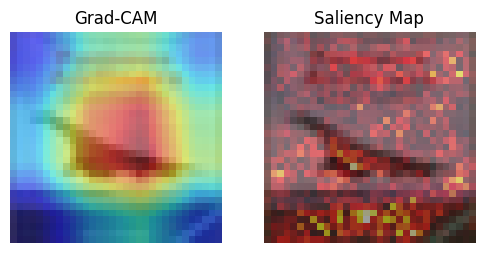

True: horse, Predicted: dog


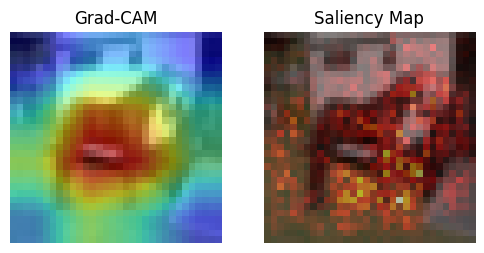

True: deer, Predicted: cat


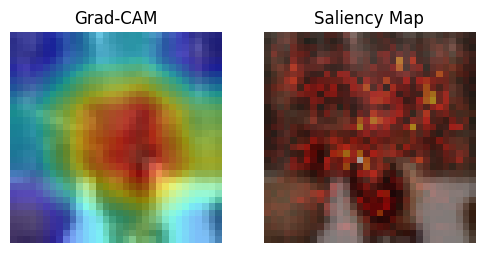

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18


# CONFIG

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "best_model.pth"
stats = ((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
NUM_FAILURES = 3


# LOAD TEST DATA

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
classes = testset.classes


# LOAD TRAINED MODEL

model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3,64,3,1,1,bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(512,10))
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE).eval()


# GRAD-CAM HOOKS

gradients, activations = None, None
def save_gradients(module, grad_in, grad_out):  global gradients; gradients = grad_out[0]
def save_activations(module, input, output):   global activations; activations = output
target_layer = model.layer4[1].conv2
target_layer.register_forward_hook(save_activations)
target_layer.register_full_backward_hook(save_gradients)  # avoids warning


# FUNCTIONS

def gradcam(img_tensor, class_idx=None):
    img_tensor = img_tensor.unsqueeze(0).to(DEVICE)
    output = model(img_tensor)
    if class_idx is None: class_idx = output.argmax(dim=1).item()
    model.zero_grad()
    output[0,class_idx].backward()
    pooled_grads = torch.mean(gradients, dim=[0,2,3])
    cam = torch.zeros(activations.shape[2:], dtype=torch.float32).to(DEVICE)
    for i, w in enumerate(pooled_grads): cam += w * activations[0,i,:,:]
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()
    # Resize to image size
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(32,32), mode='bilinear', align_corners=False)
    return cam.squeeze().cpu().detach().numpy(), class_idx

def saliency_map(img_tensor, target_class=None):
    img_tensor = img_tensor.unsqueeze(0).to(DEVICE)
    img_tensor.requires_grad = True
    output = model(img_tensor)
    if target_class is None: target_class = output.argmax(dim=1).item()
    model.zero_grad()
    output[0,target_class].backward()
    saliency,_ = torch.max(img_tensor.grad.abs(), dim=1)
    return saliency.squeeze().cpu().numpy()

def show_overlay(img_tensor, grad_cam, saliency):
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = np.clip(img*stats[1]+stats[0],0,1)
    
    plt.figure(figsize=(6,6))
    # Grad-CAM overlay
    plt.subplot(1,2,1)
    plt.title("Grad-CAM")
    plt.imshow(img)
    plt.imshow(grad_cam, cmap='jet', alpha=0.5)
    plt.axis('off')
    # Saliency overlay
    plt.subplot(1,2,2)
    plt.title("Saliency Map")
    plt.imshow(img)
    plt.imshow(saliency, cmap='hot', alpha=0.5)
    plt.axis('off')
    plt.show()


# RUN ANALYSIS ON FIRST 3 FAILURES

failures = 0
for img_tensor, label in testloader:
    img_tensor = img_tensor[0]
    label = label.item()
    
    # Prediction
    output = model(img_tensor.unsqueeze(0).to(DEVICE))
    pred_class = output.argmax(dim=1).item()
    
    if pred_class != label:
        # Generate Grad-CAM and Saliency Map
        cam, _ = gradcam(img_tensor, class_idx=pred_class)
        saliency = saliency_map(img_tensor, target_class=pred_class)
        print(f"True: {classes[label]}, Predicted: {classes[pred_class]}")
        show_overlay(img_tensor, cam, saliency)
        
        failures += 1
        if failures >= NUM_FAILURES:
            break


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import time


# CONFIG

class Config:
    EPOCHS = 50
    BATCH_SIZE = 64
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# DATA NORMALIZATION

stats = ((0.4914, 0.4822, 0.4465),
         (0.2023, 0.1994, 0.2010))

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=Config.BATCH_SIZE,
    shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=Config.BATCH_SIZE,
    shuffle=False, num_workers=2)


# MODEL (NO PRETRAINED)

model = resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(512, 10)
)

model = model.to(Config.DEVICE)


# LOSS

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)


# OPTIMIZER (ADAM)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3,          # Correct LR for Adam
    weight_decay=1e-4
)


# COSINE SCHEDULER

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=Config.EPOCHS,
    eta_min=1e-5
)


# TRAINING

best_val_acc = 0
start_time = time.time()

for epoch in range(Config.EPOCHS):

   history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

best_val_acc = 0

for epoch in range(Config.EPOCHS):

    # TRAIN 
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()

    train_loss /= len(trainloader)
    train_acc = 100. * train_correct / train_total

    #  VALIDATION
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

    val_loss /= len(testloader)
    val_acc = 100. * val_correct / val_total

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch+1:02d}/50] | "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}% | "
          f"LR: {scheduler.get_last_lr()[0]:.6f}")


Epoch [01/50] | Train Loss: 2.2065 | Train Acc: 21.33% | Test Loss: 1.8691 | Test Acc: 38.43% | LR: 0.00165
Epoch [02/50] | Train Loss: 2.0173 | Train Acc: 30.35% | Test Loss: 1.7834 | Test Acc: 43.46% | LR: 0.00298
Epoch [03/50] | Train Loss: 1.9372 | Train Acc: 35.18% | Test Loss: 1.6907 | Test Acc: 47.99% | LR: 0.00510
Epoch [04/50] | Train Loss: 1.8605 | Train Acc: 39.40% | Test Loss: 1.6363 | Test Acc: 52.35% | LR: 0.00789
Epoch [05/50] | Train Loss: 1.7927 | Train Acc: 43.47% | Test Loss: 1.5547 | Test Acc: 55.88% | LR: 0.01115
Epoch [06/50] | Train Loss: 1.7262 | Train Acc: 47.35% | Test Loss: 1.5107 | Test Acc: 59.60% | LR: 0.01470
Epoch [07/50] | Train Loss: 1.6796 | Train Acc: 49.75% | Test Loss: 1.4507 | Test Acc: 61.73% | LR: 0.01830
Epoch [08/50] | Train Loss: 1.6383 | Train Acc: 52.03% | Test Loss: 1.3667 | Test Acc: 66.42% | LR: 0.02174
Epoch [09/50] | Train Loss: 1.5995 | Train Acc: 54.25% | Test Loss: 1.4294 | Test Acc: 63.61% | LR: 0.02478
Epoch [10/50] | Train Loss: 

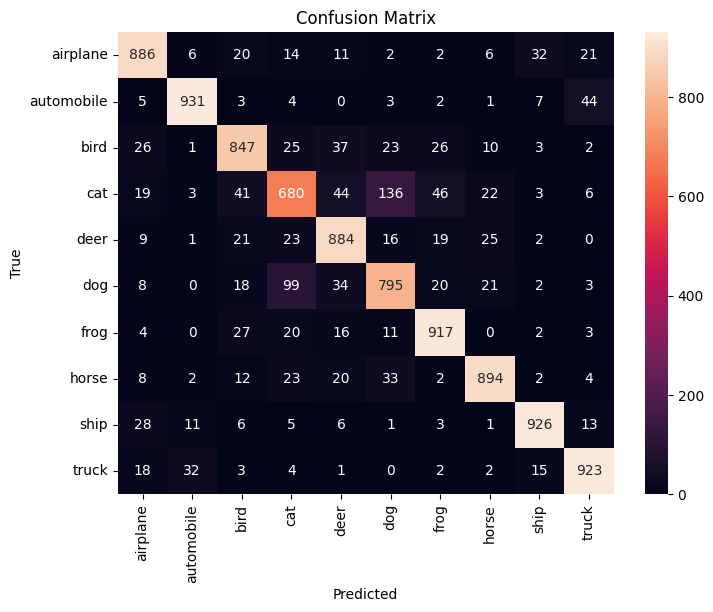

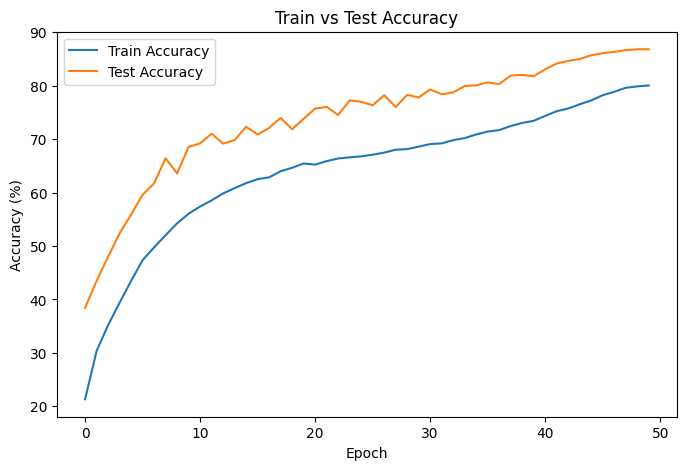

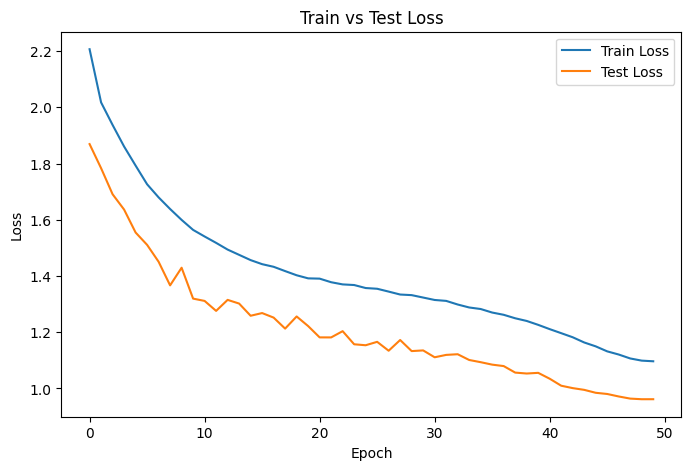

In [51]:



# CONFIG

class Config:
    BATCH_SIZE = 128
    EPOCHS = 50
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# DATA TRANSFORMS

mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


# DATASETS

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=Config.BATCH_SIZE,
    shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=Config.BATCH_SIZE,
    shuffle=False, num_workers=2)

classes = trainset.classes


# MODEL

model = resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(512, 10)
)
model = model.to(Config.DEVICE)


# LOSS + OPTIMIZER

criterion = nn.CrossEntropyLoss(label_smoothing=0.15)

optimizer = optim.SGD(
    model.parameters(),
    lr=0.03,
    momentum=0.9,
    weight_decay=1e-3,
    nesterov=True
)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.03,
    epochs=Config.EPOCHS,
    steps_per_epoch=len(trainloader),
    pct_start=0.25,
    anneal_strategy='cos'
)


# TRAINING LOOP

best_test_acc = 0

history = {
    'train_acc': [],
    'test_acc': [],
    'train_loss': [],
    'test_loss': []
}

start_time = time.time()

for epoch in range(Config.EPOCHS):

    # TRAIN 
    model.train()
    train_correct = 0
    train_total = 0
    train_running_loss = 0.0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
        scheduler.step()

        train_running_loss += loss.item() * inputs.size(0)

        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()

    train_loss = train_running_loss / train_total
    train_acc = 100. * train_correct / train_total

    # TEST 
    model.eval()
    test_correct = 0
    test_total = 0
    test_running_loss = 0.0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_running_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)
            test_total += targets.size(0)
            test_correct += predicted.eq(targets).sum().item()

    test_loss = test_running_loss / test_total
    test_acc = 100. * test_correct / test_total

    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch+1:02d}/{Config.EPOCHS}] "
          f"| Train Loss: {train_loss:.4f} "
          f"| Train Acc: {train_acc:.2f}% "
          f"| Test Loss: {test_loss:.4f} "
          f"| Test Acc: {test_acc:.2f}% "
          f"| LR: {scheduler.get_last_lr()[0]:.5f}")

print("\nBest Test Accuracy:", best_test_acc)
print("Training Time: {:.2f} mins".format((time.time()-start_time)/60))


# LOAD BEST MODEL

model.load_state_dict(torch.load("best_model.pth"))
model.eval()


# CLASSIFICATION REPORT

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in testloader:
        inputs = inputs.to(Config.DEVICE)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.numpy())

print("\nClassification Report:\n")
print(classification_report(all_targets, all_preds, target_names=classes))


# CONFUSION MATRIX

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# ACCURACY CURVE

plt.figure(figsize=(8,5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.show()


# LOSS CURVE

plt.figure(figsize=(8,5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Configuration

class Config:
    EPOCHS = 50
    LR = 3e-4
    WEIGHT_DECAY = 5e-4


# Model

model = RegularCNN()   # our model
model = model.to(device)


# Loss

criterion = nn.CrossEntropyLoss()


# Optimizer (Correct AdamW setup)

optimizer = optim.AdamW(
    model.parameters(),
    lr=Config.LR,
    weight_decay=Config.WEIGHT_DECAY
)


# Scheduler (Proper OneCycleLR)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-4,
    epochs=Config.EPOCHS,
    steps_per_epoch=len(trainloader),
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=10,
    final_div_factor=100
)


# Training Loop

best_acc = 0

for epoch in range(Config.EPOCHS):

    #  TRAIN 
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
        scheduler.step()   # correct placement (per batch)

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_acc = 100. * correct / total
    train_loss /= len(trainloader)

    # TEST
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_acc = 100. * correct / total
    test_loss /= len(testloader)

    current_lr = scheduler.get_last_lr()[0]

    print(f"Epoch [{epoch+1:02d}/{Config.EPOCHS}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}% | "
          f"LR: {current_lr:.6f}")

    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "best_model.pth")

print(f"\nBest Test Accuracy: {best_acc:.2f}%")


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

classes = trainset.classes

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

print(classification_report(all_targets, all_preds, target_names=classes))


              precision    recall  f1-score   support

    airplane       0.87      0.88      0.87      1000
  automobile       0.93      0.92      0.92      1000
        bird       0.86      0.82      0.84      1000
         cat       0.73      0.74      0.74      1000
        deer       0.85      0.87      0.86      1000
         dog       0.79      0.78      0.78      1000
        frog       0.90      0.91      0.91      1000
       horse       0.91      0.89      0.90      1000
        ship       0.90      0.92      0.91      1000
       truck       0.89      0.90      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



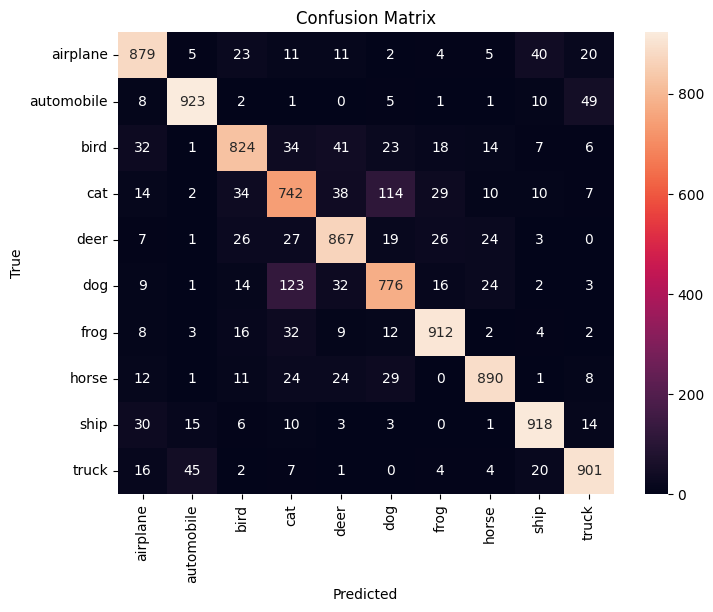

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Overall Accuracy:", accuracy_score(all_targets, all_preds))
print("Macro Precision:", precision_score(all_targets, all_preds, average='macro'))
print("Macro Recall:", recall_score(all_targets, all_preds, average='macro'))
print("Macro F1 Score:", f1_score(all_targets, all_preds, average='macro'))


Overall Accuracy: 0.8632
Macro Precision: 0.8632592147811688
Macro Recall: 0.8632000000000002
Macro F1 Score: 0.8631398021712166
